# Predicting Survivors on Titanic

In This notebook, I'll build a model to predict the survivors on titanic, given various features...using Kaggle titanic dataset

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Loading training and test data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


It shows that Age contains many missing values, and 
Very less instances have non-null Cabin attribute.

In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


This shows that about 75% of people did not survive...and 75% of people on titanic were less than 38 years)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

# Data Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4739703400>,
      dtype=object)

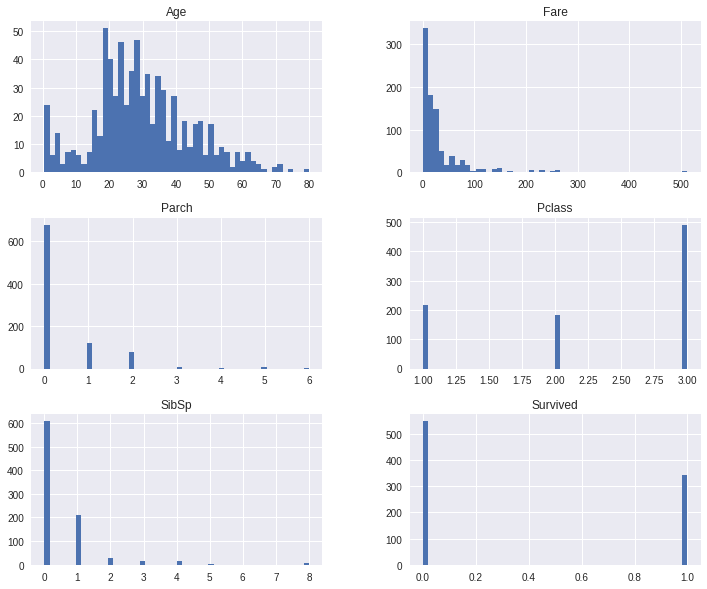

In [6]:
plt.style.use('seaborn')
train[['Age','Fare','Parch','Pclass','SibSp','Survived']].hist(bins = 50, figsize = (12,10))

From the Plots we Can observe that:

1.) Age and Fare are not bell shaped and are tail heavy, so we need to normalize these for better performance

2.) Age of majority of people on titanic is around 20-30 years

3.) Large number of people were travelling without family members

4.) Majority of people on ship were third class ticket category people

Let us now look at the effect of various features on the survival of person

In [7]:
survived_byclass = train.groupby('Pclass').Survived.mean()
survived_bygender = train.groupby('Sex').Survived.mean()
survived_byage = train.groupby('Age').Survived.mean()

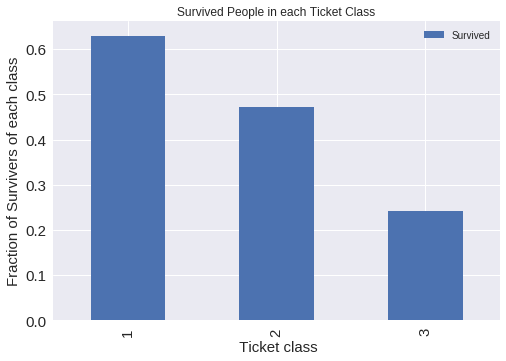

In [8]:
survived_byclass.plot(kind = 'bar', fontsize  = 15)
plt.title('Survived People in each Ticket Class')
plt.xlabel(' Ticket class', fontsize = 15)
plt.ylabel('Fraction of Survivers of each class', fontsize = 15)
plt.legend()

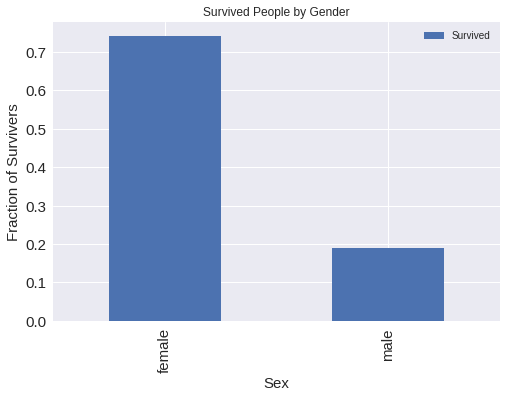

In [9]:
survived_bygender.plot(kind = 'bar', fontsize = 15)
plt.title('Survived People by Gender')
plt.xlabel('Sex', fontsize = 15)
plt.ylabel('Fraction of Survivers', fontsize = 15)
plt.legend()

Text(0, 0.5, 'Fraction of Survivers')

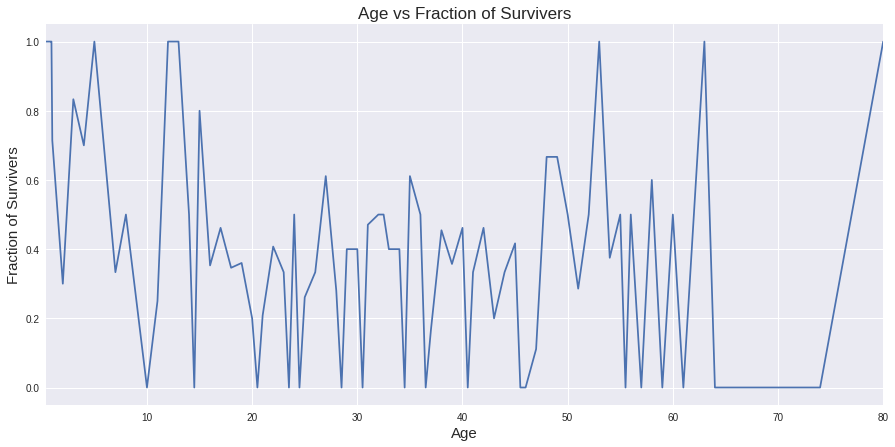

In [10]:
survived_byage.plot(kind = 'line', figsize = (15,7))
plt.title('Age vs Fraction of Survivers', fontsize = 17)
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Fraction of Survivers', fontsize = 15)

Inferences::

1.) From 1st figure we see that Higher class people were more influential so they survived and poor died

2.) From 2nd figure we see that females had better chances of survival than males

3.) The older and children people survived, whereas the adult people died...This was perhaps because the adult people
    were busy saving everyone

We can see that Age, Sex, Ticket class are pretty important attributes for predictions

# Data Preparation and Feature Engineering

We need to split the label from dataset

In [11]:
train_x = train.drop('Survived', axis = 1)
train_y = train['Survived']

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

In [13]:
class dropaddfeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self,X,y=None):
        X = X.drop('Ticket',axis = 1)
        X['Name'] = X['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
        X['Cabin'] = X['Cabin'].apply(lambda x: str(x)[0] if not pd.isnull(x) else 'Unknown')
        X['Family'] = X['SibSp'] + X['Parch']
        X = X.rename(columns = {'Name' : 'Title', 'Cabin' : 'Deck'})
        X['Sex'] = X['Sex'].apply(lambda x: 1 if x == 'male' else 0)
        X['Family-Fare'] = (X['Family']+1) * X['Fare']
        X['Embarked'] = X['Embarked'].apply(lambda x: x if not pd.isnull(x) else 'Unknown')
        return X
        

In [14]:
transformer = dropaddfeatures()
temp = transformer.transform(train_x)
temp.head()

,PassengerId,Pclass,Title,Sex,Age,SibSp,Parch,Fare,Deck,Embarked,Family,Family-Fare
0,1,3,Mr,1,22.0,1,0,7.2500,Unknown,S,1,14.5000
1,2,1,Mrs,0,38.0,1,0,71.2833,C,C,1,142.5666
2,3,3,Miss,0,26.0,0,0,7.9250,Unknown,S,0,7.9250
3,4,1,Mrs,0,35.0,1,0,53.1000,C,S,1,106.2000
4,5,3,Mr,1,35.0,0,0,8.0500,Unknown,S,0,8.0500


The new dataset looks somewhat better. But we still need to convert the categorical variables to numbers for Machine Learning Algorithm to work..

First Let us Analyse the Title Categories..

In [15]:
temp.Title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
Jonkheer          1
Sir               1
the Countess      1
Capt              1
Lady              1
Don               1
Mme               1
Ms                1
Name: Title, dtype: int64

Since The Major Categories are Mr, Miss, Mrs and Master, so let us convert other titles into those

In [16]:
def converttitles(row):
    if row.Title == 'Mr' or row.Title == 'Mrs' or row.Title == 'Master' or row.Title == 'Miss':
        row.Title = row.Title
    elif row.Sex == 1 and row.Age < 18:
        row.Title = 'Master'
    elif row.Sex == 1 and row.Age >= 18:
        row.Title = 'Mr'
    elif row.Sex == 0 and row.Age > 26:
        row.Title = 'Mrs'
    else:
        row.Title = 'Miss'
    return row

In [17]:
class newtitles(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        X = X.apply(converttitles, axis = 1)
        return X

In [18]:
t_changer = newtitles()
temp = t_changer.fit_transform(temp)
temp.head()

,PassengerId,Pclass,Title,Sex,Age,SibSp,Parch,Fare,Deck,Embarked,Family,Family-Fare
0,1,3,Mr,1,22.0,1,0,7.2500,Unknown,S,1,14.5000
1,2,1,Mrs,0,38.0,1,0,71.2833,C,C,1,142.5666
2,3,3,Miss,0,26.0,0,0,7.9250,Unknown,S,0,7.9250
3,4,1,Mrs,0,35.0,1,0,53.1000,C,S,1,106.2000
4,5,3,Mr,1,35.0,0,0,8.0500,Unknown,S,0,8.0500


In [19]:
temp.Title.value_counts()

Mr        536
Miss      186
Mrs       129
Master     40
Name: Title, dtype: int64

Now, we need to convert Categorical variables Title, Deck, Embarked to numbers and Normalize the values..

In [20]:
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [21]:
class encode(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        self.enc1 = LabelEncoder()
        self.enc2 = LabelEncoder()
        self.enc3 = LabelEncoder()
        self.enc1.fit(X['Title'])
        self.enc2.fit(X['Deck'])
        self.enc3.fit(X['Embarked'])
    def transform(self,X,y=None):
        X['Title'] = self.enc1.transform(X['Title'])
        X['Deck'] = self.enc2.transform(X['Deck'])
        X['Embarked'] = self.enc3.transform(X['Embarked'])
        return X.values

Let us now build a pipeline for this transformations

In [22]:
data_clean = Pipeline([
    ('dropadd',dropaddfeatures()),
    ('dec_titles',newtitles()),
    ('label_encode',encode()),
])
data_prepare = Pipeline([
    ('imputer',SimpleImputer()),
    ('scaler',StandardScaler())
])


In [23]:
X = data_clean.fit(train_x).transform(train_x)
X = data_prepare.fit(X).transform(X)
X

array([[-1.73010796,  0.82737724,  0.21541946, ...,  0.58111394,
         0.05915988, -0.38704001],
       [-1.72622007, -1.56610693,  1.61643213, ..., -1.93846038,
         0.05915988,  0.38471232],
       [-1.72233219,  0.82737724, -1.18559321, ...,  0.58111394,
        -0.56097483, -0.42666214],
       ...,
       [ 1.72233219,  0.82737724, -1.18559321, ...,  0.58111394,
         1.29942929,  0.09083603],
       [ 1.72622007, -1.56610693,  0.21541946, ..., -1.93846038,
        -0.56097483, -0.29363422],
       [ 1.73010796,  0.82737724,  0.21541946, ..., -0.67867322,
        -0.56097483, -0.42771672]])

Finally we have made the pipelines for data_cleaning and preparation and have prepared the data for training the algorithm

# Model Selection and Cross validation

In [24]:
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,accuracy_score

In [25]:
import warnings
warnings.filterwarnings('ignore')

# RandomForest Classifier

In [26]:
ranfor_clf = RandomForestClassifier(n_estimators = 50)
prediction = cross_val_predict(ranfor_clf,X,train_y,cv = 5)
acc = accuracy_score(prediction,train_y)
pre = precision_score(prediction,train_y)
recall = recall_score(prediction,train_y)
f1 = f1_score(prediction,train_y)
print('Accuracy = ',acc,'\nPrecision = ',pre,'\nRecall = ',recall,'\nf1_score = ',f1)

Accuracy =  0.8170594837261503 
Precision =  0.6988304093567251 
Recall =  0.7993311036789298 
f1_score =  0.7457098283931357


# Neural Network

In [27]:
mlp_clf = MLPClassifier()
prediction = cross_val_predict(mlp_clf,X,train_y,cv = 5)
acc = accuracy_score(prediction,train_y)
pre = precision_score(prediction,train_y)
recall = recall_score(prediction,train_y)
f1 = f1_score(prediction,train_y)
print('Accuracy = ',acc,'\nPrecision = ',pre,'\nRecall = ',recall,'\nf1_score = ',f1)

Accuracy =  0.8080808080808081 
Precision =  0.6783625730994152 
Recall =  0.7918088737201365 
f1_score =  0.7307086614173227


# SGD Classifier

In [28]:
sgd_clf = SGDClassifier()
prediction = cross_val_predict(sgd_clf,X,train_y,cv = 5)
acc = accuracy_score(prediction,train_y)
pre = precision_score(prediction,train_y)
recall = recall_score(prediction,train_y)
f1 = f1_score(prediction,train_y)
print('Accuracy = ',acc,'\nPrecision = ',pre,'\nRecall = ',recall,'\nf1_score = ',f1)

Accuracy =  0.7351290684624018 
Precision =  0.6871345029239766 
Recall =  0.6456043956043956 
f1_score =  0.6657223796033995


# KNeighborsClassifier

In [29]:
knn_clf = KNeighborsClassifier(n_neighbors = 5)
prediction = cross_val_predict(knn_clf,X,train_y,cv = 5)
acc = accuracy_score(prediction,train_y)
pre = precision_score(prediction,train_y)
recall = recall_score(prediction,train_y)
f1 = f1_score(prediction,train_y)
print('Accuracy = ',acc,'\nPrecision = ',pre,'\nRecall = ',recall,'\nf1_score = ',f1)

Accuracy =  0.813692480359147 
Precision =  0.716374269005848 
Recall =  0.7802547770700637 
f1_score =  0.7469512195121951


# HyperParameter Tuning and Model Selection

From the above metrics, we can see that RandomForest works best..Now let's Tweak its hyperparameters
to  improve accuracy

In [30]:
from sklearn.model_selection import RandomizedSearchCV

In [31]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
max_features = ['auto','sqrt']
max_depth = [int(x) for x in np.linspace(start = 10, stop = 30, num = 3)]
min_samples_split = [2,5,7,10]
min_samples_leaf = [1,2,4,7]
bootstrap = [True,False]

random_grid = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'max_depth' : max_depth,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf,
    'bootstrap' : bootstrap
}

In [32]:
ranfor_clf = RandomForestClassifier()
ran_cv = RandomizedSearchCV(estimator = ranfor_clf, param_distributions = random_grid,n_iter = 100,
                           cv = 6,random_state = 42, n_jobs = -1)

In [33]:
ran_cv.fit(X,train_y)

RandomizedSearchCV(cv=6, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 7, 10], 'min_samples_leaf': [1, 2, 4, 7], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [34]:
ran_cv.best_score_

0.8451178451178452

In [35]:
final_model = ran_cv.best_estimator_

# Evaluation on Test set

In [36]:
test_x = data_clean.transform(test)
test_x = data_prepare.transform(test_x)

In [37]:
prediction = final_model.predict(test_x)
submit_file = pd.DataFrame({'PassengerId' : test.PassengerId.values, 'Survived' : prediction},
                          index = np.arange(len(prediction)))

In [38]:
submit_file.set_index(submit_file['PassengerId'])
submit_file.to_csv('predictions.csv')

In [39]:
actual_values = pd.read_csv('gender_submission.csv')

In [40]:
acc = accuracy_score(actual_values.Survived.values,prediction)
print('Accuracy on Test Set = ',acc)

Accuracy on Test Set =  0.8636363636363636


This Jupyter Notebook presented the Solution of Kaggle's Titanic Competition, to predict the survivors on titanic